In [293]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [294]:
import pandas as pd
import os
os.chdir("/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSys_Course_AT_PoliMi")

In [295]:
# Get the data
interactions_and_impressions = pd.read_csv(
    'kaggle_challenges/challenge/interactions_and_impressions.csv',
    header=0,
    dtype={0:int, 1:int, 2:str, 3:bool}
)
interactions_and_impressions.columns = ['user_id', 'item_id', 'impressions', 'data']
icm_length = pd.read_csv('kaggle_challenges/challenge/data_ICM_length.csv')
icm_type = pd.read_csv('kaggle_challenges/challenge/data_ICM_type.csv')

In [296]:
# transform interactions into ratings
view_ratings = interactions_and_impressions[interactions_and_impressions['data'] == 0]\
    .groupby(['item_id', 'user_id']).size().to_frame().reset_index()
view_ratings.columns = ['item_id', 'user_id', 'view_count']

open_ratings = interactions_and_impressions[interactions_and_impressions['data'] == 1]\
    .groupby(['item_id', 'user_id']).size().to_frame().reset_index()
open_ratings.columns = ['item_id', 'user_id', 'open_count']

interactions = pd.merge(
    left=interactions_and_impressions.groupby('user_id').size().to_frame().reset_index()['user_id'],
    right=view_ratings,
    how='left',
    on=['user_id']
)

interactions = pd.merge(
    left=interactions,
    right=open_ratings,
    how='outer',
    on=['item_id', 'user_id'],
)
interactions.columns = ['user_id', 'item_id', 'view_count', 'open_count']

interactions = pd.merge(
    left=interactions,
    right=icm_length[['item_id', 'data']],
    on=['item_id'],
    how='left'
)

interactions.columns = ['user_id', 'item_id', 'view_count', 'open_count', 'length']

interactions = pd.merge(
    left=interactions,
    right=icm_type[['item_id', 'feature_id']],
    on=['item_id'],
    how='left'
)

interactions.columns = ['user_id', 'item_id', 'view_count', 'open_count', 'length', 'type']

interactions['view_count'].fillna(0, inplace=True)
interactions['open_count'].fillna(0, inplace=True)
#interactions['length'].fillna(1, inplace=True)

interactions[interactions.item_id == 21]

,user_id,item_id,view_count,open_count,length,type
0,0,21,3.0,9.0,27.0,4.0
353,14,21,1.0,0.0,27.0,4.0
366,15,21,2.0,3.0,27.0,4.0
386,16,21,1.0,0.0,27.0,4.0
580,25,21,1.0,1.0,27.0,4.0
...,...,...,...,...,...,...
1055318,41593,21,0.0,1.0,27.0,4.0
1055319,41599,21,0.0,1.0,27.0,4.0
1055320,41601,21,0.0,1.0,27.0,4.0
1055321,41604,21,0.0,1.0,27.0,4.0


In [297]:
def process_data(interactions: pd.DataFrame):
    unique_users = interactions.user_id.unique()
    unique_items = interactions.item_id.unique()

    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()

    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)
    print(len(interactions))

    return num_users, num_items

In [298]:
num_users, num_items = process_data(interactions_and_impressions)

41629 0 41628
24507 0 24506
5826506


In [299]:
# Dataset splitting
from sklearn.model_selection import train_test_split

def dataset_splits(interactions, num_users, num_items, testing_percentage: float):
    seed = 1234

    interactions_train, interactions_test = train_test_split(interactions, test_size=testing_percentage, shuffle=True,
                                                             random_state=seed)

    return interactions_train, interactions_test


original_interactions_train, original_interactions_test = dataset_splits(
    interactions,
    num_users=num_users,
    num_items=num_items,
    testing_percentage=0.15
)

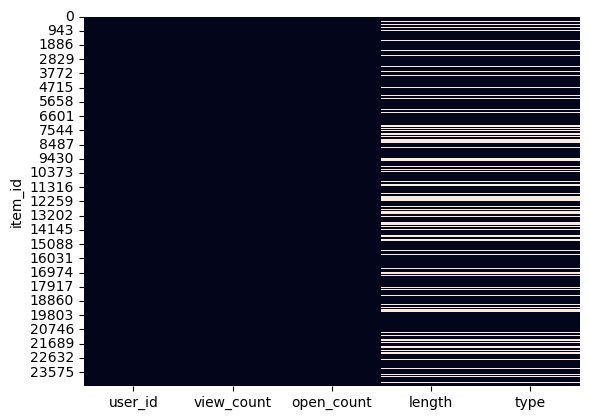

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

data = original_interactions_train.copy().groupby('item_id', dropna=False).mean()

sns.heatmap(data.isna(), cbar=False)
plt.show()

In [301]:
tmp = data[['length', 'type', 'view_count', 'open_count']].copy()

tmp['length_type'] = tmp['length'].apply(
    lambda  x: "Value" if not pd.isna(x) else "NA"
)

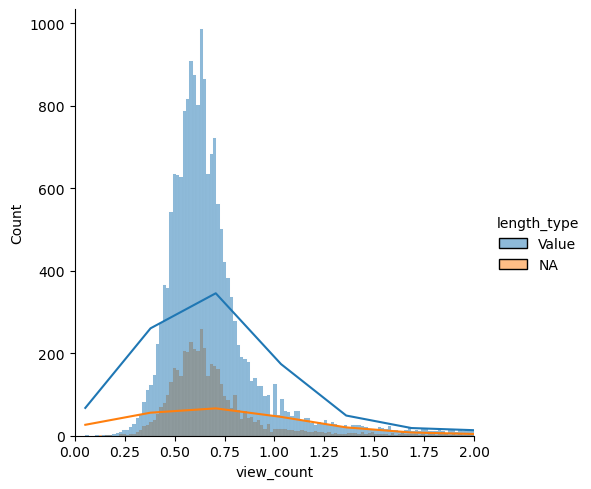

In [302]:
sns.displot(data=tmp, x='view_count', hue='length_type', kde=True)
plt.xlim(0, 2)
plt.show()

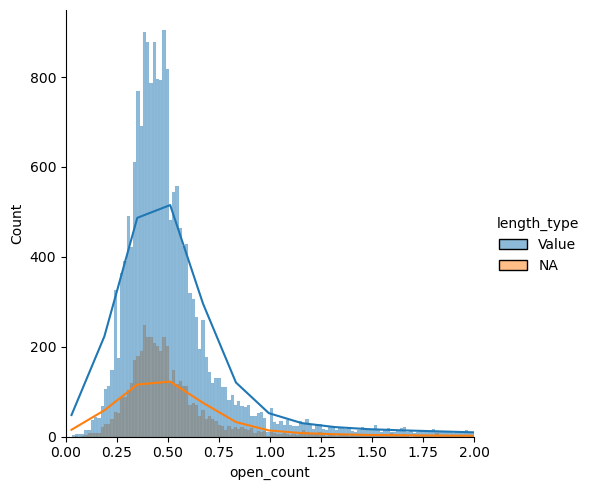

In [303]:
sns.displot(data=tmp, x='open_count', hue='length_type', kde=True)
plt.xlim(0, 2)
plt.show()

[autoreload of recommender failed: Traceback (most recent call last):
  File "/Users/federicobono/opt/anaconda3/envs/RecSysFramework/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/federicobono/opt/anaconda3/envs/RecSysFramework/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/federicobono/opt/anaconda3/envs/RecSysFramework/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/federicobono/opt/anaconda3/envs/RecSysFramework/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/Users/federicobono/opt/anaconda3/envs/RecSysFramework/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 276, in update_instances
    refs = gc.get_referrers(old)
KeyboardI

KeyboardInterrupt: 

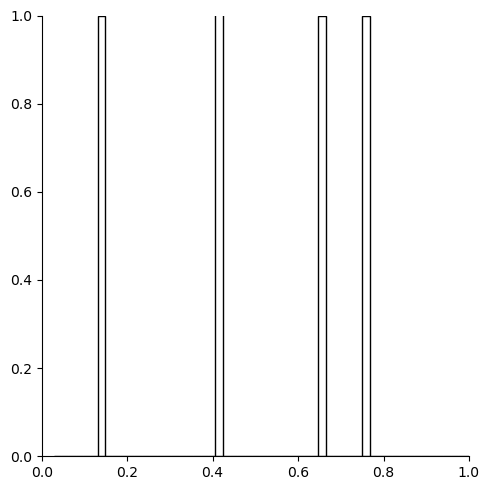

In [304]:
sns.displot(data=tmp, x='open_count', hue='type', palette=['blue', 'green', 'orange', 'purple', 'white'], kde=True)
plt.xlim(0, 1)
plt.show()

In [ ]:
sns.displot(data=tmp, x='view_count', hue='type', palette=['blue', 'green', 'orange', 'purple', 'white'], kde=True)
plt.xlim(0, 1)
plt.show()

In [ ]:
sns.displot(data=tmp, x='length', hue='type', palette=['blue', 'green', 'orange', 'purple', 'white'], kde=True)
plt.show()

In [ ]:
from recommender import DataProcessor, Hyperparameters, RatingWeights

interactions_train = original_interactions_train.copy()

hyperparams = Hyperparameters(
    shrink=25,
    top_k=50,
    rating_weights=RatingWeights(
        view_rating=0.60,
        open_rating=0.10,
        completion_rating=0.30,
        item_weight=0.1,
        user_weight=0.9,
        open_shrink=25,
        view_shrink=0,
        average_top_k=3
    )
)

data_processor = DataProcessor(data=interactions_train, params=hyperparams, num_users=num_users, num_items=num_items)

data = data_processor.process_data().data

In [ ]:
user_means = data[data.user_id == 8693]
user_means

In [ ]:
user_means = data.copy()
user_means[user_means.is_valid != 1].groupby("user_id").size()

In [ ]:
user_means.is_valid.fillna(0, inplace=True)
user_means.groupby('is_valid').size()

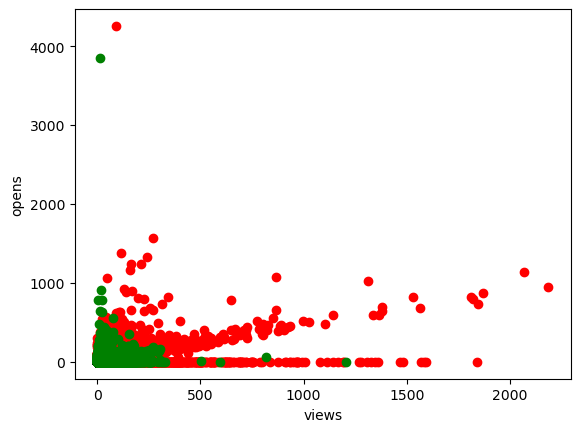

In [292]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)


plt.plot(user_means.view_count[user_means.is_valid != 1], user_means.open_count[user_means.is_valid != 1], 'o', c='red')
plt.plot(user_means.view_count[user_means.is_valid == 1], user_means.open_count[user_means.is_valid == 1], 'o', c='green')

plt.ylabel("opens")
plt.xlabel("views")
plt.show()
# plt.plot(user_means.open_count, 'red')

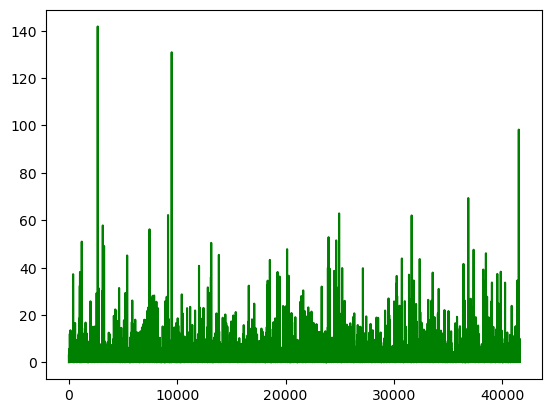

In [57]:
plt.plot(user_means.completion, 'green')

In [58]:
item_means = data.groupby(['item_id']).mean()
item_means

,user_id,view_count,open_count,length,type,total_interactions_count,item_avg_view,user_avg_view,item_avg_open,user_avg_open,completion,item_avg_completion,user_avg_completion,view_ratings,open_ratings,completion_ratings,ratings
item_id,,,,,,,,,,,,,,,,,
0,18402.379310,0.413793,0.620690,1.0,1.0,1.034483,1.333333,23.954023,1.000000,6.482759,0.413793,1.333333,20.475819,0.159281,0.021103,0.171545,0.536062
1,20064.180556,0.430556,0.680556,1.0,3.0,1.111111,2.000000,19.569444,2.333333,18.083333,0.430556,2.000000,12.931864,0.161720,0.020432,0.197948,0.538238
2,21129.763158,0.631579,0.473684,21.0,4.0,1.105263,1.333333,10.070175,1.333333,10.289474,0.030075,0.063492,7.896617,0.270448,0.013621,0.059474,0.544544
3,22344.425532,0.680851,0.404255,1.0,1.0,1.085106,2.000000,11.829787,1.333333,11.446809,0.680851,2.000000,7.786356,0.299145,0.011617,0.321158,0.566643
4,17599.113208,0.679245,0.603774,1.0,3.0,1.283019,1.666667,20.012579,2.666667,14.069182,0.679245,1.666667,17.637317,0.287045,0.015815,0.321247,0.564871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24502,22762.000000,0.473684,0.578947,1.0,1.0,1.052632,1.333333,27.491228,1.000000,5.754386,0.473684,1.333333,24.517012,0.158804,0.020244,0.168829,0.535577
24503,24869.200000,0.520000,0.480000,6.0,4.0,1.000000,1.000000,5.640000,1.000000,3.146667,0.086667,0.166667,4.622222,0.260236,0.016941,0.091705,0.545220
24504,23650.250000,0.500000,0.500000,1.0,1.0,1.000000,1.000000,6.933333,1.000000,4.800000,0.500000,1.000000,3.749495,0.271177,0.017502,0.304608,0.561133


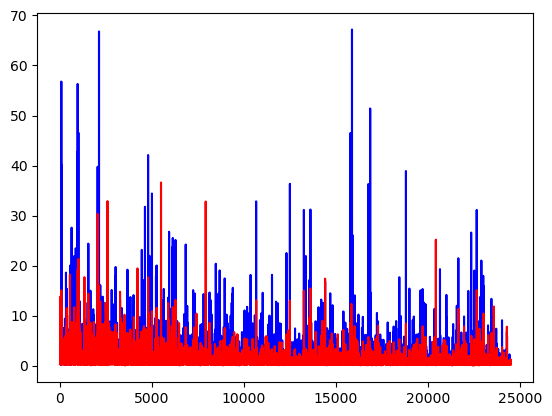

In [72]:
plt.plot(item_means.view_count, 'blue')
plt.plot(item_means.open_count, 'red')

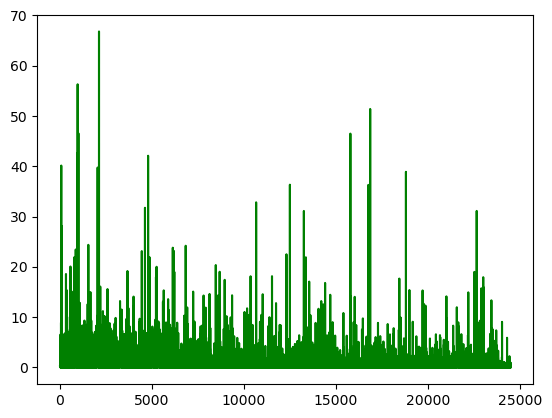

In [60]:
plt.plot(item_means.completion, 'green')

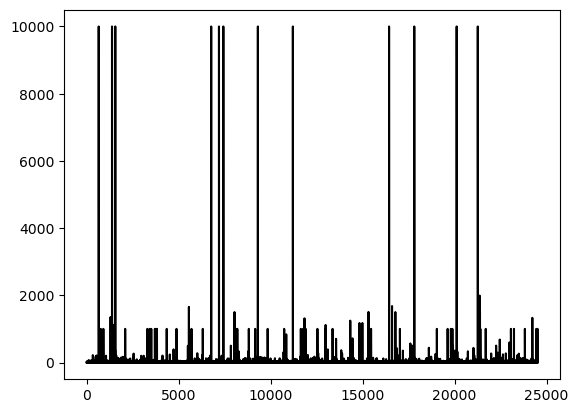

In [61]:
plt.plot(item_means.length, 'black')

In [97]:
types_means = data.groupby('type').mean()
types_count = data.groupby('item_id').mean().groupby('type').size()
types_means

,user_id,item_id,view_count,open_count,length,total_interactions_count,item_avg_view,user_avg_view,item_avg_open,user_avg_open,completion,item_avg_completion,user_avg_completion,view_ratings,open_ratings,completion_ratings,ratings
type,,,,,,,,,,,,,,,,,
1.0,19577.124092,8413.238859,2.116416,1.304722,1.516764,3.421138,29.274664,18.229687,24.972734,13.366836,1.750654,23.389345,14.074906,0.261876,0.025603,0.267361,0.557239
2.0,19473.043840,7416.443244,2.578470,2.264325,1.772101,4.842795,51.137083,18.306443,72.517996,14.205909,2.352442,47.594601,14.260826,0.279269,0.037360,0.306271,0.562119
3.0,19555.117847,8099.197249,2.642312,1.484003,1.012670,4.126316,41.294873,18.301982,35.235561,13.316951,2.639680,41.285068,14.219094,0.280250,0.028316,0.329214,0.563680
4.0,19569.929066,8373.493054,2.434200,1.666811,55.736209,4.101011,43.041720,18.102736,70.938895,13.457926,0.300076,4.723330,13.742866,0.274218,0.029873,0.075264,0.545927
7.0,18942.638677,3913.898219,0.888041,0.687023,25.890585,1.575064,3.757422,9.996607,5.069550,10.654792,0.040670,0.175351,7.972064,0.265605,0.019921,0.039101,0.542560


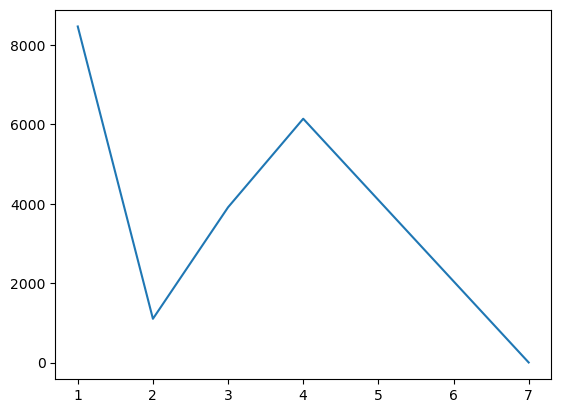

In [98]:
plt.plot(types_count)

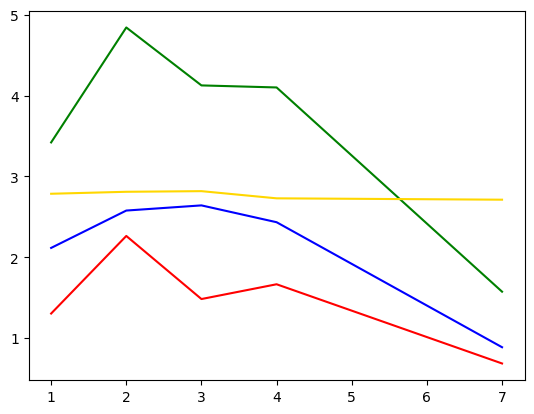

In [70]:
plt.plot(types_means.view_count, 'blue')
plt.plot(types_means.open_count, 'red')
plt.plot(types_means.total_interactions_count, 'green')
plt.plot(types_means.ratings * 5, 'gold')

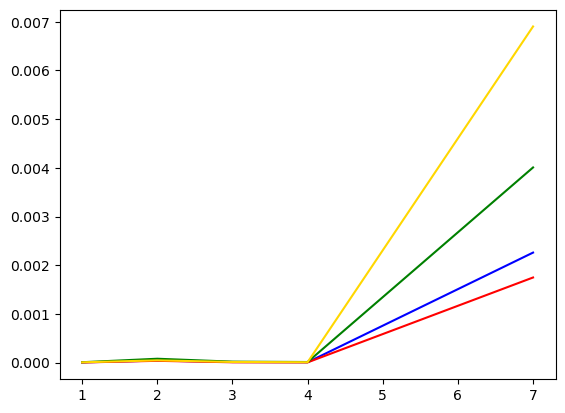

In [92]:
plt.plot(types_means.view_count / types_count, 'blue')
plt.plot(types_means.open_count / types_count, 'red')
plt.plot(types_means.total_interactions_count / types_count, 'green')
plt.plot(types_means.ratings * 5 / types_count, 'gold')

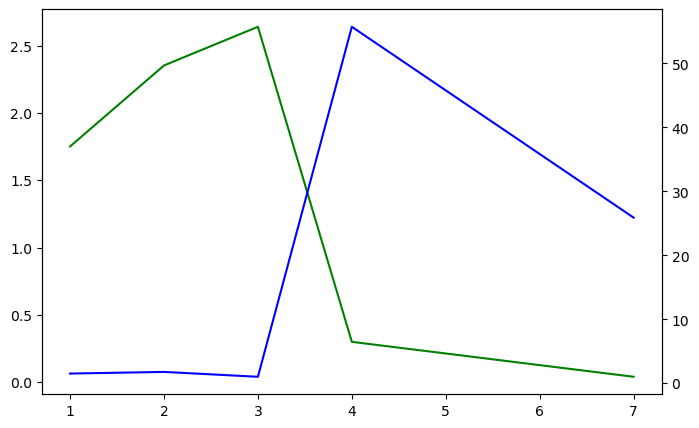

In [86]:
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches

par2 = host.twinx()

host.plot(types_means.completion, 'green')
par2.plot(types_means.length, 'blue')